# UC Berkeley Machine Learning and Artificial Intelligence Capstone Project

### Research Question
Can we build a model to predict whether a police call will result in an arrest or citation?

### Data Source
* San Jose Police Calls For Service: https://data.sanjoseca.gov/dataset/police-calls-for-service.

In [227]:
import warnings
# Ignore future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import glob
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import folium
import numpy as np
from folium.plugins import HeatMap
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, recall_score, f1_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay

In [7]:
# For testing purposes, just use one year's worth of data
police_csv_files = glob.glob("data/police/policecalls2018.csv.neighborhood.csv")

# List to hold dataframes
police_dfs = []

# Loop through the list of files and read them into dataframes
for file in police_csv_files:
    df = pd.read_csv(file)
    police_dfs.append(df)

# Concatenate all dataframes into one
all_police_df = pd.concat(police_dfs, ignore_index=True)

print(len(all_police_df))

322365


In [9]:
all_police_df.sample(5)

,CDTS,EID,START_DATE,CALL_NUMBER,PRIORITY,REPORT_DATE,OFFENSE_DATE,OFFENSE_TIME,CALLTYPE_CODE,CALL_TYPE,FINAL_DISPO_CODE,FINAL_DISPO,ADDRESS,CITY,STATE,LATITUDE,LONGITUDE,neighborhood
15708,20180120043324PS,7024604,5/14/2021 12:00:00 AM,P180200067,5,1/20/2018 12:00:00 AM,1/20/2018 12:00:00 AM,01:28:14,23152,MISDEMEANOR DUI,N,No report required; dispatch r,TULLY RD & CORDE TERRA CL,San Jose,CA,37.333148,-121.806960,The Glens
162681,20180704030135PD,7246423,5/14/2021 12:00:00 AM,P181850107,2,7/4/2018 12:00:00 AM,7/4/2018 12:00:00 AM,02:14:34,415,DISTURBANCE,N,No report required; dispatch r,[2100]-[2200] MONTEREY RD,San Jose,CA,37.307510,-121.859451,Spartan Keyes and Wool Creek
139115,20180608170443PD,7211405,5/14/2021 12:00:00 AM,P181590652,4,6/8/2018 12:00:00 AM,6/8/2018 12:00:00 AM,16:01:04,22500,PARKING VIOLATION,N,No report required; dispatch r,[800]-[900] EMORY ST,San Jose,CA,37.329272,-121.938226,O'Connor
146160,20180616073511PD,7221863,5/14/2021 12:00:00 AM,P181670233,4,6/16/2018 12:00:00 AM,6/16/2018 12:00:00 AM,07:10:55,22500,PARKING VIOLATION,E,"Traffic Citation Issued, Non-H",[1600]-[1700] TROON DR,San Jose,CA,37.346462,-121.852938,Pink Elephant and PAL
139540,20180609021059PD,7212021,5/14/2021 12:00:00 AM,P181591175,3,6/8/2018 12:00:00 AM,6/8/2018 12:00:00 AM,23:22:54,1125,TRAFFIC HAZARD,R,Report taken,SILVER CREEK VALLEY RD & FARNS,San Jose,CA,37.295956,-121.785046,Silver Creek Country Club


In [11]:
all_police_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322365 entries, 0 to 322364
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   CDTS              322365 non-null  object 
 1   EID               322365 non-null  int64  
 2   START_DATE        322365 non-null  object 
 3   CALL_NUMBER       322365 non-null  object 
 4   PRIORITY          322365 non-null  int64  
 5   REPORT_DATE       322365 non-null  object 
 6   OFFENSE_DATE      322365 non-null  object 
 7   OFFENSE_TIME      322365 non-null  object 
 8   CALLTYPE_CODE     322365 non-null  object 
 9   CALL_TYPE         322365 non-null  object 
 10  FINAL_DISPO_CODE  322365 non-null  object 
 11  FINAL_DISPO       322365 non-null  object 
 12  ADDRESS           312382 non-null  object 
 13  CITY              322365 non-null  object 
 14  STATE             322365 non-null  object 
 15  LATITUDE          289212 non-null  float64
 16  LONGITUDE         28

In [13]:
all_police_df.describe()

,EID,PRIORITY,LATITUDE,LONGITUDE
count,3.223650e+05,322365.000000,289212.000000,289212.000000
mean,7.244476e+06,3.335573,37.320203,-121.870827
std,1.402516e+05,1.395846,0.043354,0.048316
min,7.000038e+06,1.000000,34.018071,-122.035696
25%,7.123786e+06,2.000000,37.295263,-121.901964
50%,7.244217e+06,3.000000,37.323591,-121.868964
75%,7.365470e+06,4.000000,37.348403,-121.837675
max,7.488584e+06,6.000000,37.534539,-117.911791


In [15]:
all_police_df.describe(include='object')

,CDTS,START_DATE,CALL_NUMBER,REPORT_DATE,OFFENSE_DATE,OFFENSE_TIME,CALLTYPE_CODE,CALL_TYPE,FINAL_DISPO_CODE,FINAL_DISPO,ADDRESS,CITY,STATE,neighborhood
count,322365,322365,322365,322365,322365,322365,322365,322365,322365,322365,312382,322365,322365,287681
unique,320127,1,316206,365,365,81044,213,206,22,18,31667,1,1,295
top,20180217091134PS,5/14/2021 12:00:00 AM,P181131012,2/9/2018 12:00:00 AM,2/9/2018 12:00:00 AM,18:51:14,415,DISTURBANCE,N,No report required; dispatch r,[1700]-[1800] AIRPORT BL,San Jose,CA,Spartan Keyes and Wool Creek
freq,3,322365,6,1039,1039,21,30824,30824,141153,141153,1289,322365,322365,8599


In [17]:
missing_data = all_police_df.isnull().sum()
missing_data

CDTS                    0
EID                     0
START_DATE              0
CALL_NUMBER             0
PRIORITY                0
REPORT_DATE             0
OFFENSE_DATE            0
OFFENSE_TIME            0
CALLTYPE_CODE           0
CALL_TYPE               0
FINAL_DISPO_CODE        0
FINAL_DISPO             0
ADDRESS              9983
CITY                    0
STATE                   0
LATITUDE            33153
LONGITUDE           33153
neighborhood        34684
dtype: int64

In [19]:
for column in all_police_df.select_dtypes(include=['object']).columns:
    unique_values = all_police_df[column].nunique()
    print(f'{column}: {unique_values} unique values')

CDTS: 320127 unique values
START_DATE: 1 unique values
CALL_NUMBER: 316206 unique values
REPORT_DATE: 365 unique values
OFFENSE_DATE: 365 unique values
OFFENSE_TIME: 81044 unique values
CALLTYPE_CODE: 213 unique values
CALL_TYPE: 206 unique values
FINAL_DISPO_CODE: 22 unique values
FINAL_DISPO: 18 unique values
ADDRESS: 31667 unique values
CITY: 1 unique values
STATE: 1 unique values
neighborhood: 295 unique values


In [21]:
all_police_df['FINAL_DISPO_CODE'].value_counts()

FINAL_DISPO_CODE
N          141153
CAN         42522
R           39976
G           21257
NR          13625
E           12319
D            8641
A            6429
DUPNCAN      5444
O            5245
H            4250
GD           4020
C            3854
B            3506
T            3217
U            2895
ADV          2783
F             980
M             105
Z              69
P              60
TOT            15
Name: count, dtype: int64

In [23]:
all_police_df['FINAL_DISPO'].value_counts()

FINAL_DISPO
No report required; dispatch r    141153
Canceled                           42522
Report taken                       39976
Gone on Arrival/unable to loca     21257
No Response                        13625
No Disposition                     12331
Traffic Citation Issued, Non-H     12319
Traffic Citation Issued, Hazar      8641
Arrest Made                         6429
Supplemental report taken           5245
Courtesy Service/Citizen or ag      4250
Criminal Citation                   3854
Arrest by Warrant                   3506
Turned over To (TOT)                3217
Unfounded event                     2895
Field Interview (F.I.) Complet       980
Stranded motorist assist             105
Prior case, follow-up activity        60
Name: count, dtype: int64

In [25]:
# Create a mapping between FINAL_DISPO_CODE and FINAL_DISPO
final_dispo_mapping = dict(zip(all_police_df['FINAL_DISPO_CODE'], all_police_df['FINAL_DISPO']))
final_dispo_mapping

{'N': 'No report required; dispatch r',
 'NR': 'No Response',
 'CAN': 'Canceled',
 'R': 'Report taken',
 'G': 'Gone on Arrival/unable to loca',
 'H': 'Courtesy Service/Citizen or ag',
 'GD': 'No Disposition',
 'DUPNCAN': 'No Disposition',
 'O': 'Supplemental report taken',
 'T': 'Turned over To (TOT)',
 'A': 'Arrest Made',
 'U': 'Unfounded event',
 'B': 'Arrest by Warrant',
 'E': 'Traffic Citation Issued, Non-H',
 'ADV': 'No Disposition',
 'D': 'Traffic Citation Issued, Hazar',
 'C': 'Criminal Citation',
 'F': 'Field Interview (F.I.) Complet',
 'Z': 'No Disposition',
 'M': 'Stranded motorist assist',
 'P': 'Prior case, follow-up activity',
 'TOT': 'No Disposition'}

## Focus on Target Dispositions

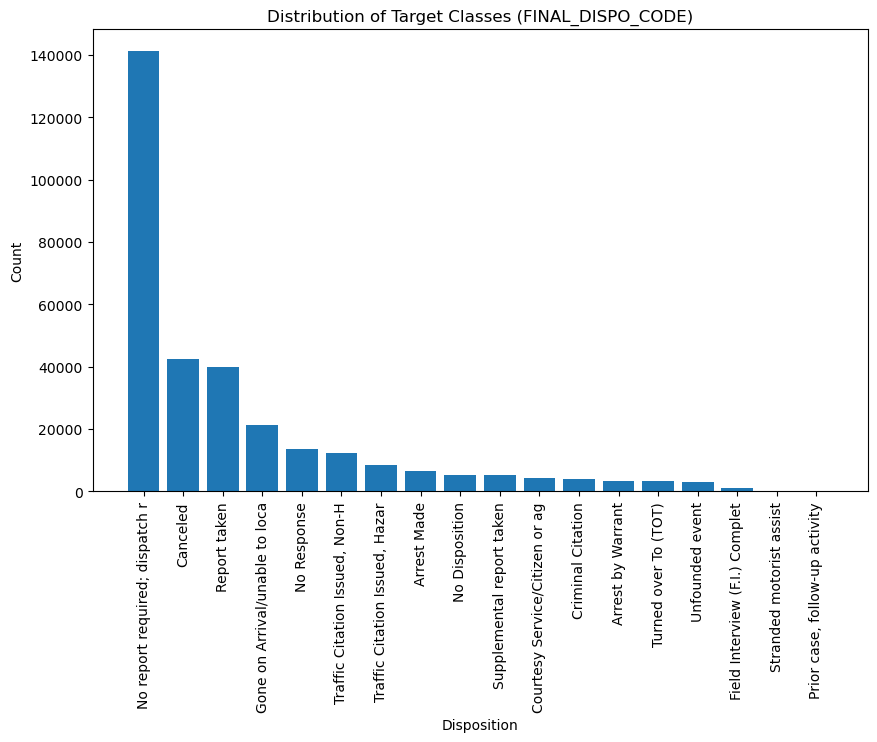

In [214]:
# Get the value counts of the DISPO_SUBSET column
dispo_counts = all_police_df['FINAL_DISPO_CODE'].value_counts()

# Create a list of names using the dispo_mapping
dispo_names = [final_dispo_mapping[code] for code in dispo_counts.index]

# Plot the distribution of target classes with disposition names
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.bar(dispo_names, dispo_counts.values)
plt.title('Distribution of Target Classes (FINAL_DISPO_CODE)')
plt.xlabel('Disposition')
plt.ylabel('Count')
plt.xticks(rotation=90)  # Rotate x-axis labels if needed
plt.show()

In [33]:
# List of target disposition codes to keep as individual classes
target_dispo_codes = ['A', 'B', 'C', 'D', 'E']

dispo_mapping = {
    'A': 'Arrest Made',
    'B': 'Arrest by Warrant',
    'C': 'Criminal Citation',
    'D': 'Traffic Citation Issued, Hazardous',
    'E': 'Traffic Citation Issued, Non-Hazardous',
    'Other': 'Other'
}

In [39]:
# Step 1: Create a new target variable where specified disposition codes remain,
# and all others are consolidated into a single class.
all_police_df['DISPO_SUBSET'] = np.where(all_police_df['FINAL_DISPO_CODE'].isin(target_dispo_codes), 
                                         all_police_df['FINAL_DISPO_CODE'], 'Other')
all_police_df['DISPO_SUBSET'].value_counts()

DISPO_SUBSET
Other    287616
E         12319
D          8641
A          6429
C          3854
B          3506
Name: count, dtype: int64

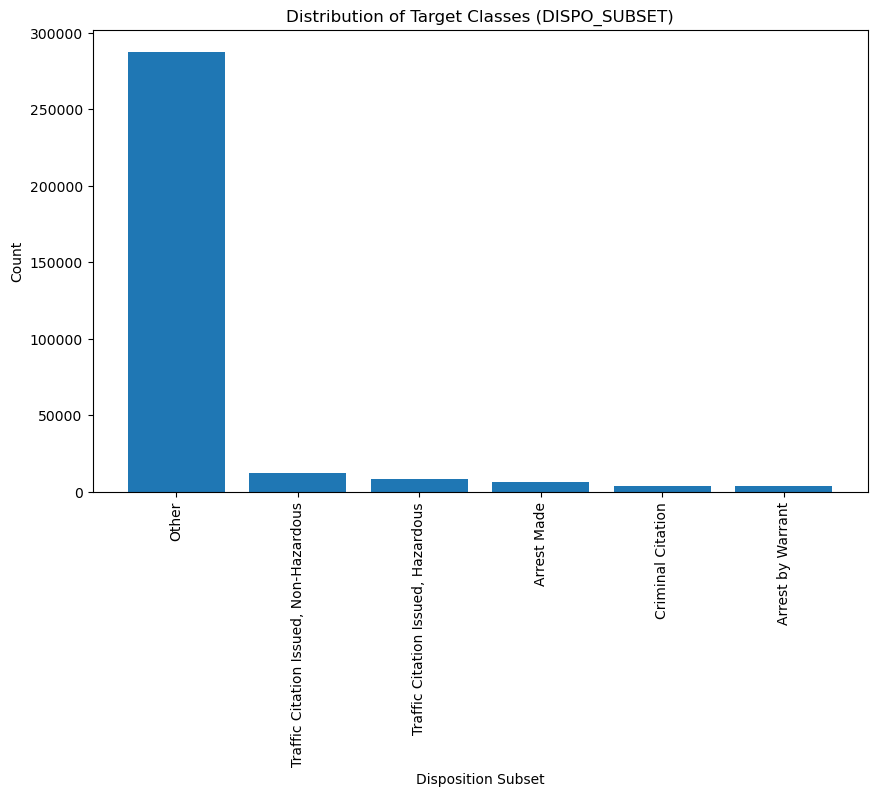

In [212]:
# Get the value counts of the DISPO_SUBSET column
dispo_counts = all_police_df['DISPO_SUBSET'].value_counts()

# Create a list of names using the dispo_mapping
dispo_names = [dispo_mapping[code] for code in dispo_counts.index]

# Plot the distribution of target classes with disposition names
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.bar(dispo_names, dispo_counts.values)
plt.title('Distribution of Target Classes (DISPO_SUBSET)')
plt.xlabel('Disposition Subset')
plt.ylabel('Count')
plt.xticks(rotation=90)  # Rotate x-axis labels if needed
plt.show()

## Clean the Data

In [59]:
# Remove rows with any missing values from the Police Calls dataset
police_calls_clean = all_police_df.dropna()
print(f"Police Calls Dataset: {all_police_df.shape[0]} rows before cleaning, {police_calls_clean.shape[0]} rows after cleaning.")

Police Calls Dataset: 322365 rows before cleaning, 287681 rows after cleaning.


In [61]:
police_calls_clean['DISPO_SUBSET'].value_counts()

DISPO_SUBSET
Other    255663
E         11723
D          7842
A          5838
C          3483
B          3132
Name: count, dtype: int64

In [63]:
# Dropping unnecessary columns 
police_calls_clean = police_calls_clean.drop( \
    columns=['CDTS', 'EID', 'CALL_NUMBER', 'START_DATE', 'REPORT_DATE', 'CITY', 'STATE', \
             'CALL_TYPE', 'FINAL_DISPO', 'FINAL_DISPO_CODE', 'ADDRESS'])

In [65]:
# Convert 'OFFENSE_DATE' to datetime to extract time-related features
police_calls_clean['OFFENSE_DATE'] = pd.to_datetime(police_calls_clean['OFFENSE_DATE'], format='%m/%d/%Y %I:%M:%S %p')

# and adding time-related features
police_calls_clean['OFFENSE_HOUR'] = police_calls_clean['OFFENSE_DATE'].dt.hour
police_calls_clean['OFFENSE_DAY_OF_WEEK'] = police_calls_clean['OFFENSE_DATE'].dt.dayofweek
police_calls_clean['OFFENSE_MONTH'] = police_calls_clean['OFFENSE_DATE'].dt.month

# Drop 'OFFENSE_DATE' now that features have been extracted
police_calls_clean = police_calls_clean.drop(columns=['OFFENSE_DATE', 'OFFENSE_TIME'])

In [67]:
# Encode categorical columns using One-Hot Encoding
police_calls_encoded = pd.get_dummies(police_calls_clean, columns=['CALLTYPE_CODE', 'neighborhood'], drop_first=True)
print("DONE")

DONE


## Define X and Y

In [86]:
# Define features and target
X = police_calls_encoded.drop(columns=['DISPO_SUBSET'])
y = police_calls_encoded['DISPO_SUBSET']

In [88]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

label_names = [dispo_mapping[code] for code in label_encoder.classes_]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

y_test_original = label_encoder.inverse_transform(y_test)
y_test_original_name = [dispo_mapping[code] for code in y_test_original]

## Evaluate Different Baseline Models

### Most Frequent Class Model

In [216]:
# Step 1: Find the most frequent class in the training set
most_frequent_class = np.bincount(y_train).argmax()

In [218]:
# Step 2: Predict the most frequent class for all samples in the test set
y_pred_baseline = [most_frequent_class] * len(y_test)

In [222]:
# Step 3: Evaluate the baseline model
print("Baseline Model (Most Frequent Class) Classification Report:")
print(classification_report(y_test, y_pred_baseline, zero_division=0, target_names=label_names))

Baseline Model (Most Frequent Class) Classification Report:
                                        precision    recall  f1-score   support

                           Arrest Made       0.00      0.00      0.00      1168
                     Arrest by Warrant       0.00      0.00      0.00       626
                     Criminal Citation       0.00      0.00      0.00       697
    Traffic Citation Issued, Hazardous       0.00      0.00      0.00      1568
Traffic Citation Issued, Non-Hazardous       0.00      0.00      0.00      2345
                                 Other       0.89      1.00      0.94     51133

                              accuracy                           0.89     57537
                             macro avg       0.15      0.17      0.16     57537
                          weighted avg       0.79      0.89      0.84     57537



### Logistic Regression

In [103]:
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_scaled, y_train)
y_pred_lr = lr_model.predict(X_test_scaled)
print("DONE")

DONE


In [105]:
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_lr, zero_division=0, target_names=label_names))

Logistic Regression Classification Report:
                                        precision    recall  f1-score   support

                           Arrest Made       0.61      0.30      0.40      1168
                     Arrest by Warrant       0.69      0.54      0.60       626
                     Criminal Citation       0.44      0.17      0.25       697
    Traffic Citation Issued, Hazardous       0.71      0.41      0.52      1568
Traffic Citation Issued, Non-Hazardous       0.53      0.24      0.33      2345
                                 Other       0.92      0.98      0.95     51133

                              accuracy                           0.91     57537
                             macro avg       0.65      0.44      0.51     57537
                          weighted avg       0.89      0.91      0.89     57537



#### Hyperparameter Tuning

In [118]:
# Define parameter grid
param_grid_lr = {
    'C': [0.1, 1, 10, 100],
    # 'penalty': ['l2'],
    # 'solver': ['lbfgs', 'liblinear', 'saga'],
    'class_weight': [None, 'balanced'] 
}

# Initialize Grid Search
grid_lr = GridSearchCV(estimator=lr_model, param_grid=param_grid_lr, 
                              cv=3, n_jobs=-1, verbose=2, scoring='recall_weighted')

# Fit Grid Search
grid_lr.fit(X_train_scaled, y_train)

# Best parameters and score
print(f"Best Parameters: {grid_lr.best_params_}")
print(f"Best Recall: {grid_lr.best_score_:.2f}")

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best Parameters: {'C': 10, 'class_weight': None}
Best Recall: 0.91


In [176]:
# Use the best estimator to make predictions
best_lr = grid_lr.best_estimator_
y_pred_best_lr = best_lr.predict(X_test_scaled)

# Evaluate the best model
print("Best Logistic Regression Classification Report for Police Calls:")
print(classification_report(y_test, y_pred_best_lr, zero_division=0, target_names=label_names))

Best Logistic Regression Classification Report for Police Calls:
                                        precision    recall  f1-score   support

                           Arrest Made       0.61      0.30      0.41      1168
                     Arrest by Warrant       0.69      0.54      0.61       626
                     Criminal Citation       0.45      0.17      0.25       697
    Traffic Citation Issued, Hazardous       0.71      0.41      0.52      1568
Traffic Citation Issued, Non-Hazardous       0.53      0.25      0.34      2345
                                 Other       0.92      0.98      0.95     51133

                              accuracy                           0.91     57537
                             macro avg       0.65      0.44      0.51     57537
                          weighted avg       0.89      0.91      0.89     57537



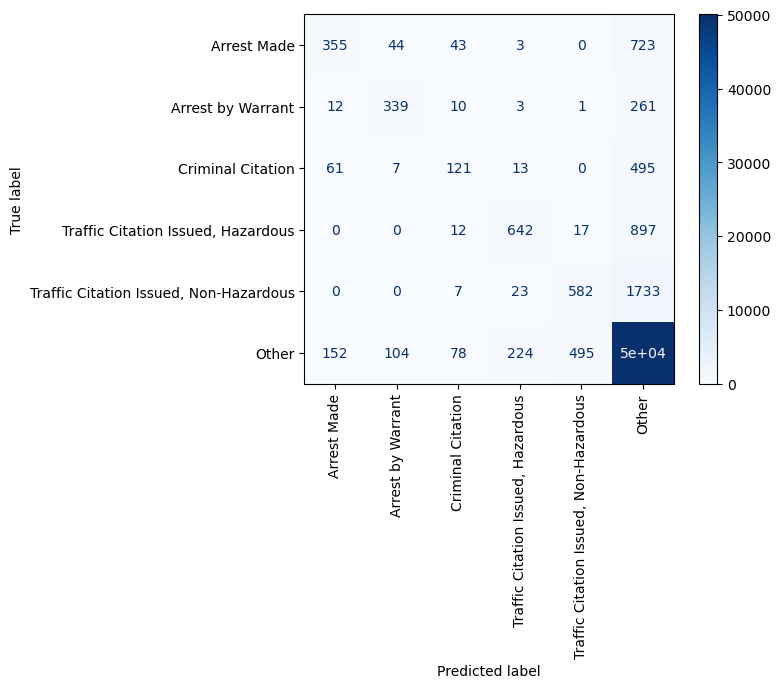

In [202]:
ConfusionMatrixDisplay.from_estimator(best_lr, X_test_scaled, y_test, display_labels=label_names, xticks_rotation=90, cmap=plt.cm.Blues)

### Random Forest

In [134]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced', n_jobs = -1)
rf_model.fit(X_train_scaled, y_train)

RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=42)

In [140]:
y_pred_rf = rf_model.predict(X_test_scaled)

print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf, zero_division=0, target_names=label_names))

Random Forest Classification Report:
                                        precision    recall  f1-score   support

                           Arrest Made       0.55      0.32      0.40      1168
                     Arrest by Warrant       0.59      0.52      0.56       626
                     Criminal Citation       0.35      0.22      0.27       697
    Traffic Citation Issued, Hazardous       0.71      0.62      0.66      1568
Traffic Citation Issued, Non-Hazardous       0.48      0.40      0.44      2345
                                 Other       0.94      0.96      0.95     51133

                              accuracy                           0.91     57537
                             macro avg       0.61      0.51      0.55     57537
                          weighted avg       0.89      0.91      0.90     57537



#### Hyperparameter Tuning

In [150]:
# Define parameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20]
}

# Initialize Grid Search
grid_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid_rf, 
                              cv=3, n_jobs=1, verbose=1, scoring='recall_weighted')

# Fit Grid Search
grid_rf.fit(X_train_scaled, y_train)

# Best parameters and score
print(f"Best Parameters: {grid_rf.best_params_}")
print(f"Best Accuracy: {grid_rf.best_score_:.2f}")

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best Parameters: {'max_depth': None, 'n_estimators': 200}
Best Accuracy: 0.91


In [155]:
# Use the best estimator to make predictions
best_rf = grid_rf.best_estimator_
y_pred_best_rf = best_rf.predict(X_test_scaled)

# Evaluate the best model
print("Best Random Forest Classification Report:")
print(classification_report(y_test, y_pred_best_rf, zero_division=0, target_names=label_names))

Best Random Forest Classification Report:
                                        precision    recall  f1-score   support

                           Arrest Made       0.56      0.31      0.40      1168
                     Arrest by Warrant       0.60      0.52      0.56       626
                     Criminal Citation       0.34      0.21      0.26       697
    Traffic Citation Issued, Hazardous       0.71      0.62      0.66      1568
Traffic Citation Issued, Non-Hazardous       0.49      0.39      0.43      2345
                                 Other       0.94      0.97      0.95     51133

                              accuracy                           0.91     57537
                             macro avg       0.61      0.50      0.54     57537
                          weighted avg       0.89      0.91      0.90     57537



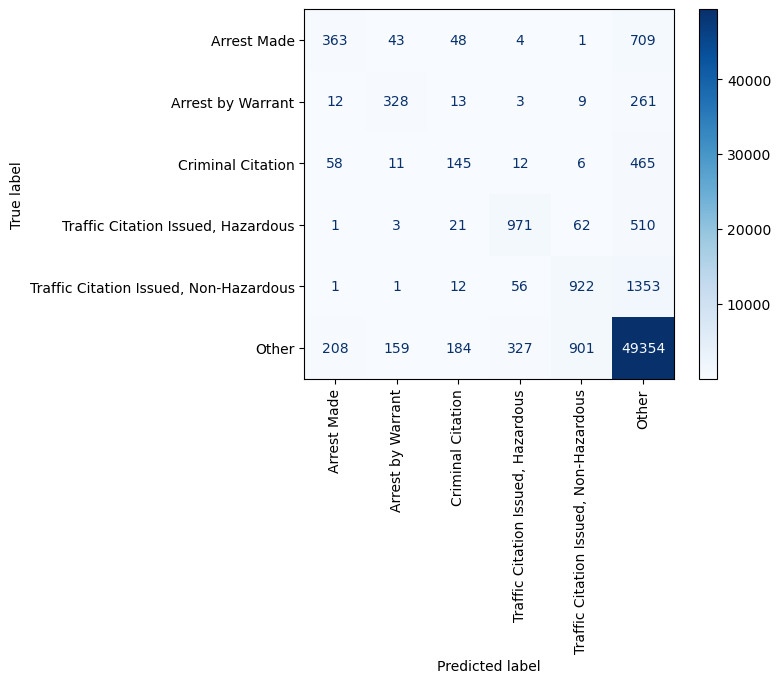

In [200]:
ConfusionMatrixDisplay.from_estimator(best_rf, X_test_scaled, y_test, display_labels=label_names, xticks_rotation=90, cmap=plt.cm.Blues)
plt.show()

### Multilayer Perceptron Model

In [164]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input

# Build the MLP model
mlp_model = Sequential()
mlp_model.add(Input(shape=(X_train_scaled.shape[1],)))
mlp_model.add(Dense(128, activation='relu'))
mlp_model.add(Dense(64, activation='relu'))
mlp_model.add(Dropout(0.2))  # Optional dropout to prevent overfitting
mlp_model.add(Dense(32, activation='relu'))
mlp_model.add(Dropout(0.2))
mlp_model.add(Dense(len(np.unique(y_train)), activation='softmax'))  # Output layer

mlp_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [166]:
# Train the model
history = mlp_model.fit(X_train_scaled, y_train, epochs=10, batch_size=64, validation_split=0.2)

Epoch 1/10
2877/2877 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8847 - loss: 0.4063 - val_accuracy: 0.9025 - val_loss: 0.2729
Epoch 2/10
2877/2877 ━━━━━━━━━━━━━━━━━━━━ 3s 965us/step - accuracy: 0.9020 - loss: 0.2867 - val_accuracy: 0.9058 - val_loss: 0.2699
Epoch 3/10
2877/2877 ━━━━━━━━━━━━━━━━━━━━ 3s 981us/step - accuracy: 0.9041 - loss: 0.2779 - val_accuracy: 0.9066 - val_loss: 0.2683
Epoch 4/10
2877/2877 ━━━━━━━━━━━━━━━━━━━━ 3s 963us/step - accuracy: 0.9029 - loss: 0.2759 - val_accuracy: 0.9064 - val_loss: 0.2678
Epoch 5/10
2877/2877 ━━━━━━━━━━━━━━━━━━━━ 3s 965us/step - accuracy: 0.9055 - loss: 0.2677 - val_accuracy: 0.9065 - val_loss: 0.2702
Epoch 6/10
2877/2877 ━━━━━━━━━━━━━━━━━━━━ 3s 970us/step - accuracy: 0.9053 - loss: 0.2680 - val_accuracy: 0.9076 - val_loss: 0.2662
Epoch 7/10
2877/2877 ━━━━━━━━━━━━━━━━━━━━ 3s 988us/step - accuracy: 0.9069 - loss: 0.2640 - val_accuracy: 0.9080 - val_loss: 0.2721
Epoch 8/10
2877/2877 ━━━━━━━━━━━━━━━━━━━━ 3s 967us/step - accuracy: 0.9085 - l

In [168]:
# Evaluate on test data
test_loss, test_acc = mlp_model.evaluate(X_test_scaled, y_test)
print(f'Test Accuracy: {test_acc:.4f}')

1799/1799 ━━━━━━━━━━━━━━━━━━━━ 1s 305us/step - accuracy: 0.9062 - loss: 0.2859
Test Accuracy: 0.9068


In [170]:
# Make predictions
y_pred_nn = mlp_model.predict(X_test_scaled)
y_pred_nn_classes = np.argmax(y_pred_nn, axis=1)

# Classification report
print("Neural Network Classification Report:")
print(classification_report(y_test, y_pred_nn_classes, zero_division=0, target_names=label_names))

1799/1799 ━━━━━━━━━━━━━━━━━━━━ 1s 290us/step
Neural Network Classification Report:
                                        precision    recall  f1-score   support

                           Arrest Made       0.58      0.34      0.43      1168
                     Arrest by Warrant       0.69      0.54      0.61       626
                     Criminal Citation       0.47      0.11      0.18       697
    Traffic Citation Issued, Hazardous       0.71      0.50      0.59      1568
Traffic Citation Issued, Non-Hazardous       0.51      0.26      0.35      2345
                                 Other       0.93      0.98      0.95     51133

                              accuracy                           0.91     57537
                             macro avg       0.65      0.45      0.52     57537
                          weighted avg       0.89      0.91      0.89     57537



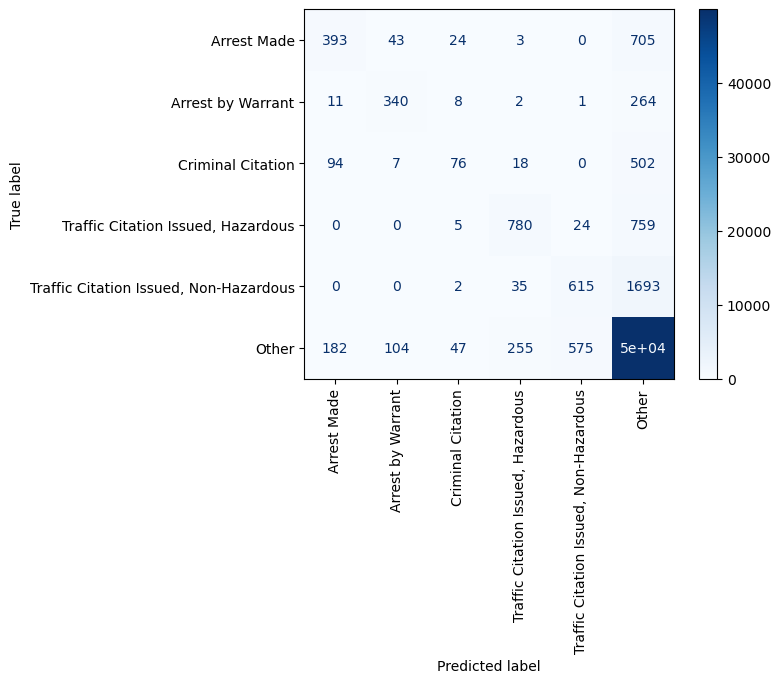

In [198]:
cm = confusion_matrix(y_test, y_pred_nn_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=90)
plt.show()

## Results

In [233]:
baseline_accuracy = accuracy_score(y_test, y_pred_baseline)
lr_accuracy = accuracy_score(y_test, y_pred_best_lr)
rf_accuracy = accuracy_score(y_test, y_pred_best_rf)
mlp_accuracy = accuracy_score(y_test, y_pred_nn_classes)

baseline_recall = recall_score(y_test, y_pred_baseline, average='weighted')
lr_recall = recall_score(y_test, y_pred_best_lr, average='weighted')
rf_recall = recall_score(y_test, y_pred_best_rf, average='weighted')
mlp_recall = recall_score(y_test, y_pred_nn_classes, average='weighted')

baseline_f1 = f1_score(y_test, y_pred_baseline, average='weighted')
lr_f1 = f1_score(y_test, y_pred_best_lr, average='weighted')
rf_f1 = f1_score(y_test, y_pred_best_rf, average='weighted')
mlp_f1 = f1_score(y_test, y_pred_nn_classes, average='weighted')

results = pd.DataFrame({
    'Model': ['Baseline', 'Logistic Regression', 'Random Forest', 'MLP'],
    'Accuracy': [baseline_accuracy, lr_accuracy, rf_accuracy, mlp_accuracy],
    'Recall': [baseline_recall, lr_recall, rf_recall, mlp_recall],
    'F1-score': [baseline_f1, lr_f1, rf_f1, mlp_f1]
})
results.set_index('Model')

,Accuracy,Recall,F1-score
Model,,,
Baseline,0.888698,0.888698,0.836326
Logistic Regression,0.905835,0.905835,0.890925
Random Forest,0.905209,0.905209,0.898289
MLP,0.906790,0.906790,0.893103
